In [1]:
import pandas as pd
import numpy as np

In [2]:
path = 'c:/data/elo/'
train_path = 'train.csv'
test_path = 'test.csv'
historical_transactions_path = 'historical_transactions.csv'
new_merchant_transactions_path = 'new_merchant_transactions.csv'
merchants_path= 'merchants.csv'

In [3]:
%matplotlib inline

In [4]:
import telepot
def send_notify(text):
    with open('../../_access_keys/telegram_token.txt', 'r') as content_file:
        token = content_file.read()
    with open('../../_access_keys/user.txt', 'r') as content_file:
        user = content_file.read()
    try:
        TelegramBot = telepot.Bot(token)
        TelegramBot.sendMessage(int(user), text)
    except:
        pass

In [5]:
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(15,10))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from datetime import datetime

In [7]:
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D, GRU, Bidirectional, LSTM, concatenate
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import regularizers

In [9]:
import lightgbm as lgb

# analyze

In [10]:
train = pd.read_csv(path + train_path)

In [11]:
train.shape

(201917, 6)

In [12]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [13]:
train['feature_3'].unique()

array([1, 0], dtype=int64)

In [14]:
train['is_train'] = True

In [15]:
test = pd.read_csv(path + test_path)

In [16]:
test.shape

(123623, 5)

In [17]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0
2,2017-08,C_ID_b709037bc5,5,1,1
3,2017-12,C_ID_d27d835a9f,2,1,0
4,2015-12,C_ID_2b5e3df5c2,5,1,1


In [18]:
test['target'] = np.nan
test['is_train'] = False

In [19]:
train_test = pd.concat((train, test))

In [24]:
train_test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,count_month
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,True,-245.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,True,-396.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,True,-549.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,True,-153.0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-92.0


In [21]:
train_test['first_active_month'] = train_test['first_active_month'].apply(pd.to_datetime)

In [22]:
max_date = train_test['first_active_month'].max()

In [23]:
train_test['count_month'] = train_test['first_active_month'] - max_date
train_test['count_month'] = train_test['count_month'].apply(lambda x:x.days)

## historical_transactions 

In [25]:
historical_transactions = pd.read_csv(path + historical_transactions_path)

In [26]:
historical_transactions.shape

(29112361, 14)

In [27]:
historical_transactions.head(3)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37


In [28]:
#historical_transactions['subsector_id'].value_counts()

In [29]:
historical_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)
historical_transactions['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
historical_transactions['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

In [30]:
sum_purchases = historical_transactions.groupby(['card_id', 'authorized_flag']).agg({'purchase_amount': [min, max, sum, np.median, np.std, 'count', np.mean]}).reset_index()
sum_purchases.columns = ['authorized_flag_' + '_'.join(x) if x[1] != '' else x[0] for x in sum_purchases.columns.ravel()]
sum_purchases.head(1)

,card_id,authorized_flag,authorized_flag_purchase_amount_min,authorized_flag_purchase_amount_max,authorized_flag_purchase_amount_sum,authorized_flag_purchase_amount_median,authorized_flag_purchase_amount_std,authorized_flag_purchase_amount_count,authorized_flag_purchase_amount_mean
0,C_ID_00007093c1,0,-0.728876,1.507069,-14.401965,-0.569219,0.430059,35,-0.411485


In [31]:
aggregate_columns = ['category_1', 'installments', 'category_3', 'merchant_category_id',\
                     'category_2', 'state_id', 'subsector_id']
aggregates_history = []
for c in aggregate_columns:
    for i in historical_transactions[c].unique():
        part_historical_transactions = historical_transactions[historical_transactions[c] == i]
        aggregate_item = part_historical_transactions.groupby(['card_id', 'authorized_flag'])\
            .agg({'purchase_amount': [min, max, sum, np.median, np.std, 'count', np.mean]}).reset_index()
        aggregate_item.columns = [c + '_' + str(i) + '_' + '_'.join(x) if x[1] != '' else x[0] for x in aggregate_item.columns.ravel()]
        aggregates_history.append(aggregate_item)
        print(c, i)

category_1 0
category_1 1
installments 0
installments 1
installments 5
installments 3
installments 4
installments 2
installments -1
installments 10
installments 6
installments 12
installments 8
installments 7
installments 9
installments 11
installments 999
category_3 0.0
category_3 1.0
category_3 2.0
category_3 nan
merchant_category_id 80
merchant_category_id 367
merchant_category_id 560
merchant_category_id 278
merchant_category_id 683
merchant_category_id 130
merchant_category_id 879
merchant_category_id 511
merchant_category_id 842
merchant_category_id 561
merchant_category_id 705
merchant_category_id 332
merchant_category_id 111
merchant_category_id 528
merchant_category_id 437
merchant_category_id 605
merchant_category_id 387
merchant_category_id 19
merchant_category_id 307
merchant_category_id 333
merchant_category_id 506
merchant_category_id 108
merchant_category_id 45
merchant_category_id 813
merchant_category_id 755
merchant_category_id 290
merchant_category_id 68
merchant_cat

merchant_category_id 523
merchant_category_id 603
merchant_category_id 145
merchant_category_id 882
merchant_category_id 322
merchant_category_id 18
merchant_category_id 875
merchant_category_id 687
merchant_category_id 86
merchant_category_id 266
category_2 1.0
category_2 nan
category_2 3.0
category_2 5.0
category_2 2.0
category_2 4.0
state_id 16
state_id 9
state_id -1
state_id 11
state_id 15
state_id 17
state_id 5
state_id 24
state_id 19
state_id 23
state_id 3
state_id 8
state_id 18
state_id 7
state_id 4
state_id 22
state_id 13
state_id 1
state_id 10
state_id 21
state_id 20
state_id 14
state_id 2
state_id 12
state_id 6
subsector_id 37
subsector_id 16
subsector_id 34
subsector_id 41
subsector_id 29
subsector_id 7
subsector_id 33
subsector_id 2
subsector_id 36
subsector_id 25
subsector_id 15
subsector_id 19
subsector_id 10
subsector_id 30
subsector_id 18
subsector_id 8
subsector_id 27
subsector_id 1
subsector_id 39
subsector_id 32
subsector_id 22
subsector_id 20
subsector_id 21
subsect

In [32]:
cities = historical_transactions['city_id'].unique()
category_1 = historical_transactions['category_1'].unique()
category_3 = historical_transactions['category_3'].unique()
merchant_category_id = historical_transactions['merchant_category_id'].unique()
category_2 = historical_transactions['category_2'].unique()
state_id = historical_transactions['state_id'].unique()
subsector_id = historical_transactions['subsector_id'].unique()

## new_merchant_transactions 

In [27]:
new_merchant_transactions = pd.read_csv(path + new_merchant_transactions_path)

In [28]:
new_merchant_transactions.shape

(1963031, 14)

In [29]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [30]:
new_merchant_transactions.drop('authorized_flag', axis=1, inplace=True)

In [31]:
new_merchant_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)

In [32]:
new_merchant_transactions['category_1'].value_counts()

0    1899935
1      63096
Name: category_1, dtype: int64

## merchants 

In [33]:
merchants = pd.read_csv(path + merchants_path)

In [34]:
merchants.shape

(334696, 22)

In [35]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [36]:
merchants['most_recent_sales_range'].unique()

array(['E', 'C', 'D', 'A', 'B'], dtype=object)

## processing

In [33]:
data = train_test.merge(sum_purchases[sum_purchases['authorized_flag'] == 0].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')
data = data.merge(sum_purchases[sum_purchases['authorized_flag'] == 1].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')

In [ ]:
count_aggregates_history = len(aggregates_history)
aggregates_history_10 = []
item_10 = None
for _item in enumerate(aggregates_history):
    index = _item[0]
    if index % 30 == 0:
        if item_10 is not None:
            aggregates_history_10.append(item_10)
        item_10 = None
    item = _item[1]
    if item_10 is None:
        item_10 = pd.DataFrame(data[['card_id']], columns=['card_id'])
    item_10 = item_10.merge(item[item['authorized_flag'] == 0].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')
    item_10 = item_10.merge(item[item['authorized_flag'] == 1].drop(['authorized_flag'], axis=1), how='left', left_on='card_id', right_on='card_id')
    print(index, '/', count_aggregates_history)
aggregates_history_10.append(item_10)

In [ ]:
count_aggregates_history = len(aggregates_history_10)
for _item in enumerate(aggregates_history_10):
    index = _item[0]
    item = _item[1]
    data = data.merge(item, how='left', left_on='card_id', right_on='card_id')
    print(index, '/', count_aggregates_history)

In [44]:
data.to_csv(path + 'data.csv', index=False)

In [35]:
data = pd.read_csv(path + 'data.csv')

In [36]:
data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,authorized_flag_purchase_amount_min_x,authorized_flag_purchase_amount_max_x,authorized_flag_purchase_amount_sum_x,...,subsector_id_28_purchase_amount_std_x,subsector_id_28_purchase_amount_count_x,subsector_id_28_purchase_amount_mean_x,subsector_id_28_purchase_amount_min_y,subsector_id_28_purchase_amount_max_y,subsector_id_28_purchase_amount_sum_y,subsector_id_28_purchase_amount_median_y,subsector_id_28_purchase_amount_std_y,subsector_id_28_purchase_amount_count_y,subsector_id_28_purchase_amount_mean_y
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True,-0.737892,-0.431922,-8.571723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True,-0.740897,1.942838,-1.122886,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True,-0.701453,-0.637515,-1.338967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-0.512945,7.193041,20.352809,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
target_columns = [str(i) for i in data.columns]
target_columns.remove('target')
target_columns.remove('is_train')
target_columns.remove('card_id')
target_columns.remove('first_active_month')

In [38]:
scaler_columns = target_columns
learn_columns = []
for i in enumerate(scaler_columns):
    index = i[0]
    column = i[1]
    min_data = data[column].min()
    if (min_data is None or np.isnan(min_data)):
        print(column, ' is nan')
        continue
    data[column].fillna(min_data, inplace=True)
    data[column] -= min_data
    data[column] /= data[column].max()
    print(index, '/', len(scaler_columns))
    learn_columns.append(column)

0 / 5897
1 / 5897
2 / 5897
3 / 5897
4 / 5897
5 / 5897
6 / 5897
7 / 5897
8 / 5897
9 / 5897
10 / 5897
11 / 5897
12 / 5897
13 / 5897
14 / 5897
15 / 5897
16 / 5897
17 / 5897
18 / 5897
19 / 5897
20 / 5897
21 / 5897
22 / 5897
23 / 5897
24 / 5897
25 / 5897
26 / 5897
27 / 5897
28 / 5897
29 / 5897
30 / 5897
31 / 5897
32 / 5897
33 / 5897
34 / 5897
35 / 5897
36 / 5897
37 / 5897
38 / 5897
39 / 5897
40 / 5897
41 / 5897
42 / 5897
43 / 5897
44 / 5897
45 / 5897
46 / 5897
47 / 5897
48 / 5897
49 / 5897
50 / 5897
51 / 5897
52 / 5897
53 / 5897
54 / 5897
55 / 5897
56 / 5897
57 / 5897
58 / 5897
59 / 5897
60 / 5897
61 / 5897
62 / 5897
63 / 5897
64 / 5897
65 / 5897
66 / 5897
67 / 5897
68 / 5897
69 / 5897
70 / 5897
71 / 5897
72 / 5897
73 / 5897
74 / 5897
75 / 5897
76 / 5897
77 / 5897
78 / 5897
79 / 5897
80 / 5897
81 / 5897
82 / 5897
83 / 5897
84 / 5897
85 / 5897
86 / 5897
87 / 5897
88 / 5897
89 / 5897
90 / 5897
91 / 5897
92 / 5897
93 / 5897
94 / 5897
95 / 5897
96 / 5897
97 / 5897
98 / 5897
99 / 5897
100 / 5897

709 / 5897
710 / 5897
711 / 5897
712 / 5897
713 / 5897
714 / 5897
715 / 5897
716 / 5897
717 / 5897
718 / 5897
719 / 5897
720 / 5897
721 / 5897
722 / 5897
723 / 5897
724 / 5897
725 / 5897
726 / 5897
727 / 5897
728 / 5897
729 / 5897
730 / 5897
731 / 5897
732 / 5897
733 / 5897
734 / 5897
735 / 5897
736 / 5897
737 / 5897
738 / 5897
739 / 5897
740 / 5897
741 / 5897
742 / 5897
743 / 5897
744 / 5897
745 / 5897
746 / 5897
747 / 5897
748 / 5897
749 / 5897
750 / 5897
751 / 5897
752 / 5897
753 / 5897
754 / 5897
755 / 5897
756 / 5897
757 / 5897
758 / 5897
759 / 5897
760 / 5897
761 / 5897
762 / 5897
763 / 5897
764 / 5897
765 / 5897
766 / 5897
767 / 5897
768 / 5897
769 / 5897
770 / 5897
771 / 5897
772 / 5897
773 / 5897
774 / 5897
775 / 5897
776 / 5897
777 / 5897
778 / 5897
779 / 5897
780 / 5897
781 / 5897
782 / 5897
783 / 5897
784 / 5897
785 / 5897
786 / 5897
787 / 5897
788 / 5897
789 / 5897
790 / 5897
791 / 5897
792 / 5897
793 / 5897
794 / 5897
795 / 5897
796 / 5897
797 / 5897
798 / 5897
799 / 5897

1421 / 5897
1422 / 5897
1423 / 5897
1424 / 5897
1425 / 5897
1426 / 5897
1427 / 5897
1428 / 5897
1429 / 5897
1430 / 5897
1431 / 5897
1432 / 5897
1433 / 5897
1434 / 5897
1435 / 5897
1436 / 5897
1437 / 5897
1438 / 5897
1439 / 5897
1440 / 5897
1441 / 5897
1442 / 5897
1443 / 5897
1444 / 5897
1445 / 5897
1446 / 5897
1447 / 5897
1448 / 5897
1449 / 5897
1450 / 5897
1451 / 5897
1452 / 5897
1453 / 5897
1454 / 5897
1455 / 5897
1456 / 5897
1457 / 5897
1458 / 5897
1459 / 5897
1460 / 5897
1461 / 5897
1462 / 5897
1463 / 5897
1464 / 5897
1465 / 5897
1466 / 5897
1467 / 5897
1468 / 5897
1469 / 5897
1470 / 5897
1471 / 5897
1472 / 5897
1473 / 5897
1474 / 5897
1475 / 5897
1476 / 5897
1477 / 5897
1478 / 5897
1479 / 5897
1480 / 5897
1481 / 5897
1482 / 5897
1483 / 5897
1484 / 5897
1485 / 5897
1486 / 5897
1487 / 5897
1488 / 5897
1489 / 5897
1490 / 5897
1491 / 5897
1492 / 5897
1493 / 5897
1494 / 5897
1495 / 5897
1496 / 5897
1497 / 5897
1498 / 5897
1499 / 5897
1500 / 5897
1501 / 5897
1502 / 5897
1503 / 5897
1504

2105 / 5897
2106 / 5897
2107 / 5897
2108 / 5897
2109 / 5897
2110 / 5897
2111 / 5897
2112 / 5897
2113 / 5897
2114 / 5897
2115 / 5897
2116 / 5897
2117 / 5897
2118 / 5897
2119 / 5897
2120 / 5897
2121 / 5897
2122 / 5897
2123 / 5897
2124 / 5897
2125 / 5897
2126 / 5897
2127 / 5897
2128 / 5897
2129 / 5897
2130 / 5897
2131 / 5897
2132 / 5897
2133 / 5897
2134 / 5897
2135 / 5897
2136 / 5897
2137 / 5897
2138 / 5897
2139 / 5897
2140 / 5897
2141 / 5897
2142 / 5897
2143 / 5897
2144 / 5897
2145 / 5897
2146 / 5897
2147 / 5897
2148 / 5897
2149 / 5897
2150 / 5897
2151 / 5897
2152 / 5897
2153 / 5897
2154 / 5897
2155 / 5897
2156 / 5897
2157 / 5897
2158 / 5897
2159 / 5897
2160 / 5897
2161 / 5897
2162 / 5897
2163 / 5897
2164 / 5897
2165 / 5897
2166 / 5897
2167 / 5897
2168 / 5897
2169 / 5897
2170 / 5897
2171 / 5897
2172 / 5897
2173 / 5897
2174 / 5897
2175 / 5897
2176 / 5897
2177 / 5897
2178 / 5897
2179 / 5897
2180 / 5897
2181 / 5897
2182 / 5897
2183 / 5897
2184 / 5897
2185 / 5897
2186 / 5897
2187 / 5897
2188

2799 / 5897
2800 / 5897
2801 / 5897
2802 / 5897
2803 / 5897
2804 / 5897
2805 / 5897
2806 / 5897
2807 / 5897
2808 / 5897
2809 / 5897
2810 / 5897
2811 / 5897
2812 / 5897
2813 / 5897
2814 / 5897
2815 / 5897
2816 / 5897
2817 / 5897
2818 / 5897
2819 / 5897
2820 / 5897
2821 / 5897
2822 / 5897
2823 / 5897
2824 / 5897
2825 / 5897
2826 / 5897
2827 / 5897
2828 / 5897
2829 / 5897
2830 / 5897
2831 / 5897
2832 / 5897
2833 / 5897
2834 / 5897
2835 / 5897
2836 / 5897
2837 / 5897
2838 / 5897
2839 / 5897
2840 / 5897
2841 / 5897
2842 / 5897
2843 / 5897
2844 / 5897
2845 / 5897
2846 / 5897
2847 / 5897
2848 / 5897
2849 / 5897
2850 / 5897
2851 / 5897
2852 / 5897
2853 / 5897
2854 / 5897
2855 / 5897
2856 / 5897
2857 / 5897
2858 / 5897
2859 / 5897
2860 / 5897
2861 / 5897
2862 / 5897
2863 / 5897
2864 / 5897
2865 / 5897
2866 / 5897
2867 / 5897
2868 / 5897
2869 / 5897
2870 / 5897
2871 / 5897
2872 / 5897
2873 / 5897
2874 / 5897
2875 / 5897
2876 / 5897
2877 / 5897
2878 / 5897
2879 / 5897
2880 / 5897
2881 / 5897
2882

3492 / 5897
3493 / 5897
3494 / 5897
3495 / 5897
3496 / 5897
3497 / 5897
3498 / 5897
3499 / 5897
3500 / 5897
3501 / 5897
3502 / 5897
3503 / 5897
3504 / 5897
3505 / 5897
3506 / 5897
3507 / 5897
3508 / 5897
3509 / 5897
3510 / 5897
3511 / 5897
3512 / 5897
3513 / 5897
3514 / 5897
3515 / 5897
3516 / 5897
3517 / 5897
3518 / 5897
3519 / 5897
3520 / 5897
3521 / 5897
3522 / 5897
3523 / 5897
3524 / 5897
3525 / 5897
3526 / 5897
3527 / 5897
3528 / 5897
3529 / 5897
3530 / 5897
3531 / 5897
3532 / 5897
3533 / 5897
3534 / 5897
3535 / 5897
3536 / 5897
3537 / 5897
3538 / 5897
3539 / 5897
3540 / 5897
3541 / 5897
3542 / 5897
3543 / 5897
3544 / 5897
3545 / 5897
3546 / 5897
3547 / 5897
3548 / 5897
3549 / 5897
3550 / 5897
3551 / 5897
3552 / 5897
3553 / 5897
3554 / 5897
3555 / 5897
3556 / 5897
3557 / 5897
3558 / 5897
3559 / 5897
3560 / 5897
3561 / 5897
3562 / 5897
3563 / 5897
3564 / 5897
3565 / 5897
3566 / 5897
3567 / 5897
3568 / 5897
3569 / 5897
3570 / 5897
3571 / 5897
3572 / 5897
3573 / 5897
3574 / 5897
3575

4173 / 5897
4174 / 5897
4175 / 5897
4176 / 5897
4177 / 5897
4178 / 5897
merchant_category_id_162_purchase_amount_std_x  is nan
4180 / 5897
4181 / 5897
4182 / 5897
4183 / 5897
4184 / 5897
4185 / 5897
4186 / 5897
4187 / 5897
4188 / 5897
4189 / 5897
4190 / 5897
4191 / 5897
4192 / 5897
4193 / 5897
4194 / 5897
4195 / 5897
4196 / 5897
4197 / 5897
4198 / 5897
4199 / 5897
4200 / 5897
4201 / 5897
4202 / 5897
4203 / 5897
4204 / 5897
4205 / 5897
4206 / 5897
4207 / 5897
4208 / 5897
4209 / 5897
4210 / 5897
4211 / 5897
4212 / 5897
4213 / 5897
4214 / 5897
4215 / 5897
4216 / 5897
4217 / 5897
4218 / 5897
4219 / 5897
4220 / 5897
4221 / 5897
4222 / 5897
4223 / 5897
4224 / 5897
4225 / 5897
4226 / 5897
4227 / 5897
4228 / 5897
4229 / 5897
4230 / 5897
4231 / 5897
4232 / 5897
4233 / 5897
4234 / 5897
4235 / 5897
4236 / 5897
4237 / 5897
4238 / 5897
4239 / 5897
4240 / 5897
4241 / 5897
4242 / 5897
4243 / 5897
4244 / 5897
4245 / 5897
4246 / 5897
4247 / 5897
4248 / 5897
4249 / 5897
4250 / 5897
4251 / 5897
4252 / 58

4670 / 5897
4671 / 5897
4672 / 5897
4673 / 5897
4674 / 5897
4675 / 5897
4676 / 5897
4677 / 5897
4678 / 5897
merchant_category_id_634_purchase_amount_min_x  is nan
merchant_category_id_634_purchase_amount_max_x  is nan
merchant_category_id_634_purchase_amount_sum_x  is nan
merchant_category_id_634_purchase_amount_median_x  is nan
merchant_category_id_634_purchase_amount_std_x  is nan
merchant_category_id_634_purchase_amount_count_x  is nan
merchant_category_id_634_purchase_amount_mean_x  is nan
4686 / 5897
4687 / 5897
4688 / 5897
4689 / 5897
4690 / 5897
4691 / 5897
4692 / 5897
merchant_category_id_579_purchase_amount_min_x  is nan
merchant_category_id_579_purchase_amount_max_x  is nan
merchant_category_id_579_purchase_amount_sum_x  is nan
merchant_category_id_579_purchase_amount_median_x  is nan
merchant_category_id_579_purchase_amount_std_x  is nan
merchant_category_id_579_purchase_amount_count_x  is nan
merchant_category_id_579_purchase_amount_mean_x  is nan
4700 / 5897
4701 / 5897
47

5028 / 5897
5029 / 5897
5030 / 5897
5031 / 5897
5032 / 5897
5033 / 5897
5034 / 5897
5035 / 5897
5036 / 5897
5037 / 5897
5038 / 5897
5039 / 5897
5040 / 5897
5041 / 5897
5042 / 5897
5043 / 5897
5044 / 5897
5045 / 5897
5046 / 5897
5047 / 5897
5048 / 5897
5049 / 5897
5050 / 5897
5051 / 5897
5052 / 5897
5053 / 5897
5054 / 5897
5055 / 5897
5056 / 5897
5057 / 5897
5058 / 5897
5059 / 5897
5060 / 5897
5061 / 5897
5062 / 5897
5063 / 5897
5064 / 5897
5065 / 5897
5066 / 5897
5067 / 5897
5068 / 5897
5069 / 5897
5070 / 5897
5071 / 5897
5072 / 5897
5073 / 5897
5074 / 5897
5075 / 5897
5076 / 5897
5077 / 5897
5078 / 5897
5079 / 5897
5080 / 5897
5081 / 5897
5082 / 5897
5083 / 5897
5084 / 5897
5085 / 5897
5086 / 5897
5087 / 5897
5088 / 5897
5089 / 5897
5090 / 5897
5091 / 5897
5092 / 5897
5093 / 5897
5094 / 5897
5095 / 5897
5096 / 5897
5097 / 5897
5098 / 5897
5099 / 5897
5100 / 5897
5101 / 5897
5102 / 5897
5103 / 5897
5104 / 5897
5105 / 5897
5106 / 5897
5107 / 5897
5108 / 5897
5109 / 5897
5110 / 5897
5111

5717 / 5897
5718 / 5897
5719 / 5897
5720 / 5897
5721 / 5897
5722 / 5897
5723 / 5897
5724 / 5897
5725 / 5897
5726 / 5897
5727 / 5897
5728 / 5897
5729 / 5897
5730 / 5897
5731 / 5897
5732 / 5897
5733 / 5897
5734 / 5897
5735 / 5897
5736 / 5897
5737 / 5897
5738 / 5897
5739 / 5897
5740 / 5897
5741 / 5897
5742 / 5897
5743 / 5897
5744 / 5897
5745 / 5897
5746 / 5897
5747 / 5897
5748 / 5897
5749 / 5897
5750 / 5897
5751 / 5897
5752 / 5897
5753 / 5897
5754 / 5897
5755 / 5897
5756 / 5897
5757 / 5897
5758 / 5897
5759 / 5897
5760 / 5897
5761 / 5897
5762 / 5897
5763 / 5897
5764 / 5897
5765 / 5897
5766 / 5897
5767 / 5897
5768 / 5897
5769 / 5897
5770 / 5897
5771 / 5897
5772 / 5897
5773 / 5897
5774 / 5897
5775 / 5897
5776 / 5897
5777 / 5897
5778 / 5897
5779 / 5897
5780 / 5897
5781 / 5897
5782 / 5897
5783 / 5897
5784 / 5897
5785 / 5897
5786 / 5897
5787 / 5897
5788 / 5897
5789 / 5897
5790 / 5897
5791 / 5897
5792 / 5897
5793 / 5897
5794 / 5897
5795 / 5897
5796 / 5897
5797 / 5897
5798 / 5897
5799 / 5897
5800

# train

In [39]:
y = data[data['is_train']]['target']

In [40]:
X = data[data['is_train']][learn_columns]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
X.shape, X.dropna().shape

((201917, 5732), (0, 5732))

In [43]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 3,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [44]:
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds=5)

[1]	valid_0's l2: 15.0074	valid_0's rmse: 3.87394
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 14.9947	valid_0's rmse: 3.8723
[3]	valid_0's l2: 14.9836	valid_0's rmse: 3.87087
[4]	valid_0's l2: 14.9742	valid_0's rmse: 3.86965
[5]	valid_0's l2: 14.9659	valid_0's rmse: 3.86858
[6]	valid_0's l2: 14.958	valid_0's rmse: 3.86756
[7]	valid_0's l2: 14.9528	valid_0's rmse: 3.86688
[8]	valid_0's l2: 14.947	valid_0's rmse: 3.86614
[9]	valid_0's l2: 14.9406	valid_0's rmse: 3.86531
[10]	valid_0's l2: 14.9353	valid_0's rmse: 3.86463
[11]	valid_0's l2: 14.9298	valid_0's rmse: 3.86391
[12]	valid_0's l2: 14.9266	valid_0's rmse: 3.86349
[13]	valid_0's l2: 14.9258	valid_0's rmse: 3.86339
[14]	valid_0's l2: 14.9234	valid_0's rmse: 3.86309
[15]	valid_0's l2: 14.9212	valid_0's rmse: 3.86279
[16]	valid_0's l2: 14.9188	valid_0's rmse: 3.86248
[17]	valid_0's l2: 14.9178	valid_0's rmse: 3.86235
[18]	valid_0's l2: 14.9148	valid_0's rmse: 3.86197
[19]	valid_0's l2: 14.9144	valid_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=3, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

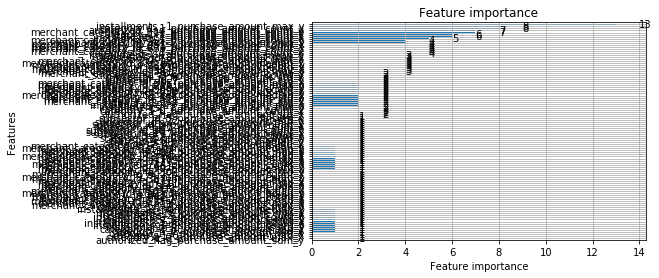

In [45]:
%matplotlib inline
lgb.plot_importance(gbm)

In [46]:
feature_importances = []
for i in zip(gbm.feature_importances_, learn_columns):
    if i[0] != 0:
        print(i[1], i[0])
        feature_importances.append(i[1])

feature_2 2
authorized_flag_purchase_amount_std_x 2
authorized_flag_purchase_amount_sum_y 1
authorized_flag_purchase_amount_count_y 8
category_1_0_purchase_amount_max_x 1
category_1_0_purchase_amount_std_x 1
category_1_0_purchase_amount_count_x 2
category_1_0_purchase_amount_count_y 2
category_1_1_purchase_amount_min_x 1
category_1_1_purchase_amount_std_x 1
category_1_1_purchase_amount_count_x 8
category_1_1_purchase_amount_mean_x 1
category_1_1_purchase_amount_count_y 7
installments_1_purchase_amount_count_x 6
installments_1_purchase_amount_std_y 1
installments_1_purchase_amount_count_y 1
installments_3_purchase_amount_median_x 1
installments_3_purchase_amount_count_x 1
installments_3_purchase_amount_min_y 1
installments_3_purchase_amount_count_y 1
installments_2_purchase_amount_sum_x 1
installments_-1_purchase_amount_min_y 2
installments_-1_purchase_amount_max_y 13
installments_-1_purchase_amount_mean_y 4
installments_10_purchase_amount_min_x 1
installments_6_purchase_amount_max_y 1


In [49]:
from sklearn.metrics import mean_squared_error

In [50]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [51]:
X_val = data[~data['is_train']][learn_columns]

In [52]:
predict = gbm.predict(X_val)

In [53]:
pd.DataFrame({'card_id':list(data[~data['is_train']]['card_id']), 'target':predict}).to_csv('output/predict_{}.csv'.format(datetime.now().strftime("%Y-%m-%d_%H_%M_%S")), index=False)

In [54]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [83]:
def create_model():
    #build Keras model
    
    x_input = Input(shape=X_train.shape[1:], dtype='float32')

    x_layer = Dense(X_train.shape[-1])(x_input)
    x_layer = Dense(1)(x_layer)
    

    model = Model(x_input, x_layer)
    model.compile(loss='mse', metrics=[root_mean_squared_error], optimizer='rmsprop')
    return model

In [84]:
count_epochs = 100
model = create_model()
early_stopping_monitor = EarlyStopping(patience=10)
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 128, epochs = count_epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])

Train on 129226 samples, validate on 32307 samples
Epoch 1/100
129226/129226 [==============================] - 1s 11us/step - loss: 14.8419 - root_mean_squared_error: 1.5901 - val_loss: 14.5406 - val_root_mean_squared_error: 1.5632
Epoch 2/100
129226/129226 [==============================] - 1s 9us/step - loss: 14.8172 - root_mean_squared_error: 1.5896 - val_loss: 14.5239 - val_root_mean_squared_error: 1.5799
Epoch 3/100
129226/129226 [==============================] - 1s 9us/step - loss: 14.8040 - root_mean_squared_error: 1.5916 - val_loss: 14.5146 - val_root_mean_squared_error: 1.5809
Epoch 4/100
129226/129226 [==============================] - 1s 10us/step - loss: 14.7942 - root_mean_squared_error: 1.5940 - val_loss: 14.5077 - val_root_mean_squared_error: 1.5762
Epoch 5/100
129226/129226 [==============================] - 1s 9us/step - loss: 14.7891 - root_mean_squared_error: 1.5949 - val_loss: 14.5061 - val_root_mean_squared_error: 1.5950
Epoch 6/100
129226/129226 [===============

In [ ]:
send_notify('complete')

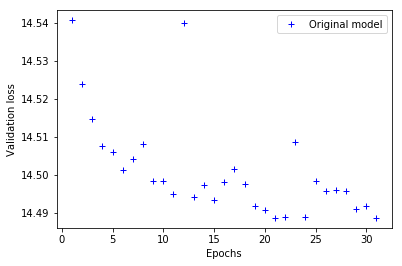

In [85]:
history_gr = history.history['val_loss']
epochs = range(1, len(history_gr) + 1)
import matplotlib.pyplot as plt

plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [86]:
model.evaluate(np.array(X_test), np.array(y_test))

40384/40384 [==============================] - 1s 20us/step


[14.939655938116381, 1.5952357023057016]

In [87]:
X_val = data[~data['is_train']][learn_columns]

In [88]:
predict = model.predict(np.array(X_val))

In [89]:
predict = gbm.predict(X_val)

In [82]:
pd.DataFrame({'card_id':list(data[~data['is_train']]['card_id']), 'target':predict.reshape(len(predict))}).to_csv('output/predict_{}.csv'.format(datetime.now().strftime("%Y-%m-%d_%H_%M_%S")), index=False)